In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.patches as mpatches
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("linear_model.txt",delimiter='\t',header=None)
data.columns=['x','y','dy']

In [3]:
def f(x,a,b):
    return a*np.cos(x)+b
def f1(x,a,b,c):
    return a*np.cos(x+c)+b

popt, pcov = curve_fit(f,data['x'].values,data['y'].values,p0=[2,2],sigma=data['dy'].values)
popt1, pcov1 = curve_fit(f1,data['x'].values,data['y'].values,p0=[2,2,0],sigma=data['dy'].values)

In [4]:
model = sp.CmdStanModel(stan_file='./stan_file.stan')
print(model.code())

INFO:cmdstanpy:found newer exe file, not recompiling


data {
	int<lower=0> n;
	vector[n] x;
	vector[n] y;
	vector[n] dy;
}
parameters {
	real a;
	real b;
}

model {
	y ~ normal(b + a * cos(x), dy);
	a ~ normal(0,100);
	b ~ normal(0,100);
}
generated quantities {
	real y_tilde[n] = normal_rng(b + a * cos(x),dy);
	vector[n] log_lik;
	vector[n] mu;
	mu=b+a*cos(x);
	for (k in 1:n){
    	log_lik[k]=normal_lpdf(y[k]|mu[k], dy[k]);
    }
}



In [5]:
stan_data={'n':len(data['x'].values),
             'x':list(data['x'].values),
             'y':list(data['y'].values),
           'dy':list(data['dy'].values)
}

fit = model.sample(data=stan_data)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


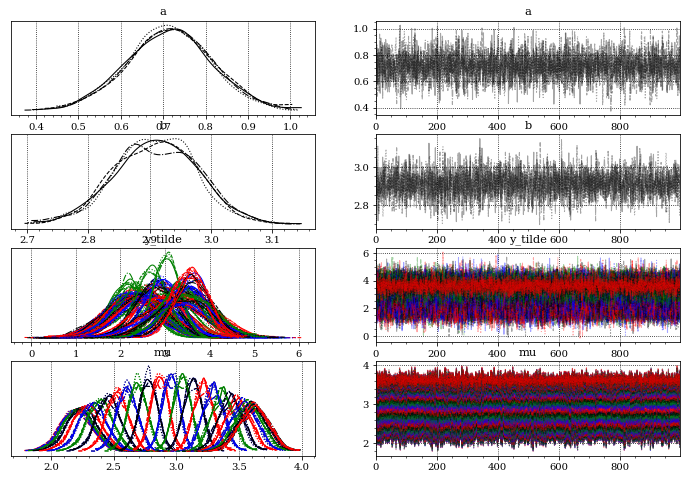

In [6]:
%%capture --no-display
warnings.filterwarnings('ignore')
az.plot_trace(fit)
plt.show()

In [7]:
samples=fit.draws_pd()
samples

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,y_tilde[1],...,mu[41],mu[42],mu[43],mu[44],mu[45],mu[46],mu[47],mu[48],mu[49],mu[50]
0,-1.63402,0.982180,0.939849,2.0,3.0,0.0,1.74538,0.691448,2.81688,3.99848,...,3.03055,3.11128,3.18737,3.25762,3.32092,3.37627,3.42280,3.45977,3.48660,3.50287
1,-1.56428,0.962802,0.939849,2.0,3.0,0.0,2.25732,0.713049,3.00093,3.80435,...,3.22127,3.30453,3.38300,3.45544,3.52072,3.57780,3.62578,3.66390,3.69157,3.70835
2,-2.45005,0.789259,0.939849,1.0,1.0,0.0,2.54597,0.708121,3.03990,3.14579,...,3.25872,3.34141,3.41933,3.49128,3.55610,3.61279,3.66043,3.69830,3.72578,3.74244
3,-1.55013,1.000000,0.939849,2.0,3.0,0.0,3.02102,0.823718,2.95295,4.32954,...,3.20749,3.30367,3.39432,3.47801,3.55341,3.61935,3.67478,3.71882,3.75079,3.77017
4,-1.93525,0.929680,0.939849,2.0,3.0,0.0,2.75681,0.574953,2.87013,2.88091,...,3.04780,3.11493,3.17820,3.23662,3.28925,3.33528,3.37396,3.40471,3.42702,3.44055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1.77206,1.000000,0.867785,2.0,3.0,0.0,2.07097,0.720907,3.01082,3.75190,...,3.23359,3.31776,3.39710,3.47034,3.53633,3.59404,3.64255,3.68110,3.70907,3.72604
3996,-3.67464,0.696914,0.867785,2.0,3.0,0.0,5.26955,0.952013,2.93395,4.42788,...,3.22813,3.33929,3.44406,3.54078,3.62793,3.70414,3.76820,3.81911,3.85605,3.87845
3997,-2.90949,1.000000,0.867785,2.0,3.0,0.0,4.15619,0.507820,2.90561,3.96827,...,3.06254,3.12183,3.17772,3.22931,3.27580,3.31645,3.35062,3.37777,3.39748,3.40943
3998,-1.48488,0.954822,0.867785,2.0,3.0,0.0,3.67384,0.615092,2.96696,3.69260,...,3.15703,3.22885,3.29654,3.35903,3.41534,3.46458,3.50597,3.53886,3.56273,3.57720


ValueError: Length of values (2) does not match length of index (50)

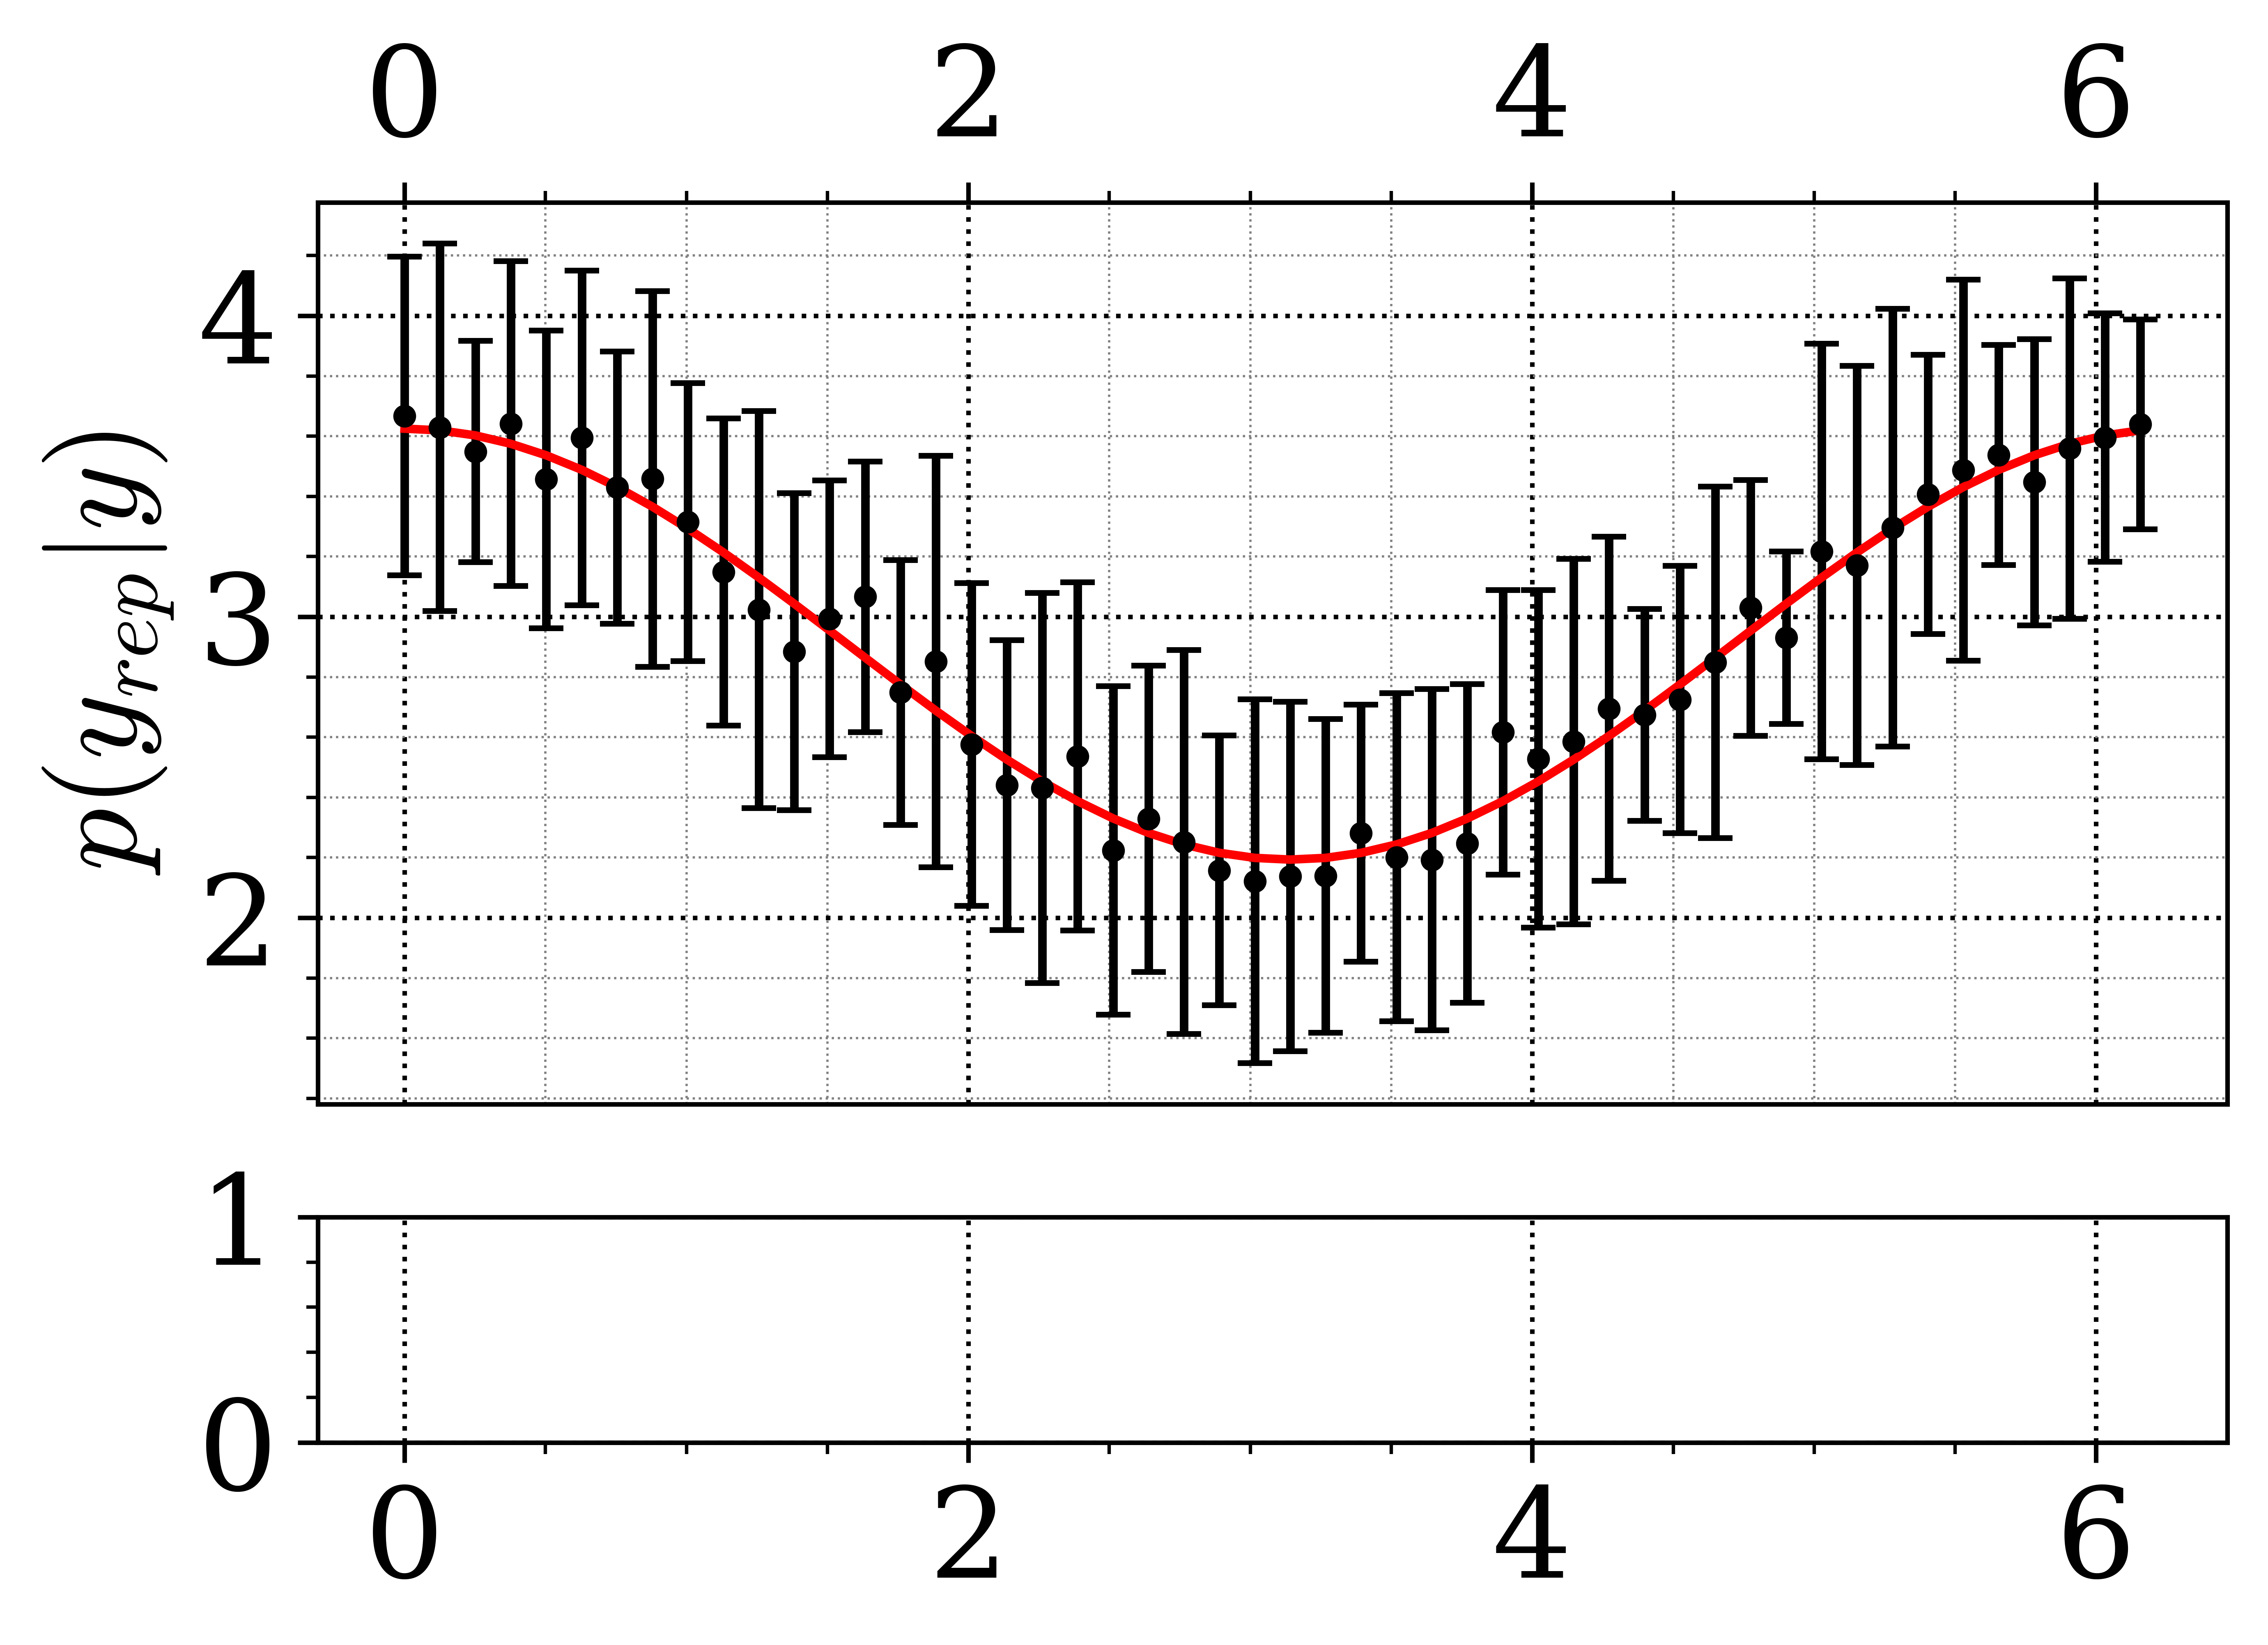

In [8]:
#cosmetics
fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
ax.set_ylabel('$p(y_{rep}|y)$')
ax.xaxis.set_ticks_position("top")
ax.grid(which='minor',color='grey',lw='.4')
#get results from chisq fit and plot them
yfit=f(data['x'],*popt)
ax.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',label='Data points')
#ax.plot(data['x'],data['y'],'x',label='Data points')
ax.plot(data['x'],yfit,'r-',label='$\chi^2$ fit',color='r')
#violinplot for the replicated samples
vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(50)],data['x'],showmeans=False, showextrema=False, showmedians=False,widths=0.2)
#cosmetics
for b in vp['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_alpha(.5)
    #b.set_color('red')

#compute p value as measure of goodness of fit
y_arr=[samples[f'y_tilde[{i+1}]']for i in range(50)]
pvalue=[len([y for y in y_arr[i] if y>=data['y'][i]])/len(y_arr[i])for i in range(50)]
#plot pvalue
ax1.grid(which='minor',color='grey',lw='.4')
ax1.plot(data['x'],pvalue,'.')
ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
ax1.set_xlabel('x')
ax1.set_ylabel('$T(y_{rep}>y)$')
#cosmetics and legend
plt.subplots_adjust(wspace=0, hspace=0)
lines,labels = ax.get_legend_handles_labels() 
patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
lines.append(patch)
lines1,labels1=ax1.get_legend_handles_labels()
lines+=lines1
tmp=lines[0]
lines[0]=lines[1]
lines[1]=tmp
plt.legend(handles=lines,bbox_to_anchor=(1,2))
plt.savefig('plot.pdf',format='pdf',bbox_inches='tight',dpi=1000)


In [ ]:
plt.hist(pvalue)

In [ ]:
pwaic=sum([np.var(samples[f'log_lik[{i+1}]'], ddof=1)for i in range(50)])
lpd=sum([np.log(np.mean(np.exp(samples[f'log_lik[{i+1}]'])))for i in range(50)])
print(lpd-pwaic)

In [ ]:
print(pwaic)

In [ ]:
model1= sp.CmdStanModel(stan_file='./stan_file1.stan')
fit1 = model1.sample(data=stan_data)
fit1.summary()
samples1=fit1.draws_pd()

In [ ]:
az.plot_trace(fit1)
plt.show()

In [ ]:
#cosmetics
fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
ax.set_ylabel('$p(y_{rep}|y)$')
ax.xaxis.set_ticks_position("top")
ax.grid(which='minor',color='grey',lw='.4')
#get results from chisq fit and plot them
yfit1=f1(data['x'],*popt1)
ax.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',label='Data points')
#ax.plot(data['x'],data['y'],'x',label='Data points')
ax.plot(data['x'],yfit1,'r-',label='$\chi^2$ fit',color='r')
#violinplot for the replicated samples
vp=ax.violinplot([samples1[f'y_tilde[{i+1}]']for i in range(50)],data['x'],showmeans=False, showextrema=False, showmedians=False,widths=0.2)
#cosmetics
for b in vp['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_alpha(.5)
    #b.set_color('red')

#compute p value as measure of goodness of fit
y_arr=[samples1[f'y_tilde[{i+1}]']for i in range(50)]
pvalue=[len([y for y in y_arr[i] if y>=data['y'][i]])/len(y_arr[i])for i in range(50)]
#plot pvalue
ax1.grid(which='minor',color='grey',lw='.4')
ax1.plot(data['x'],pvalue,'.')
ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
ax1.set_xlabel('x')
ax1.set_ylabel('$T(y_{rep}>y)$')
#cosmetics and legend
plt.subplots_adjust(wspace=0, hspace=0)
lines,labels = ax.get_legend_handles_labels() 
patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
lines.append(patch)
lines1,labels1=ax1.get_legend_handles_labels()
lines+=lines1
tmp=lines[0]
lines[0]=lines[1]
lines[1]=tmp
plt.legend(handles=lines,bbox_to_anchor=(1,2))
plt.savefig('plot1.pdf',format='pdf',bbox_inches='tight',dpi=1000)

In [ ]:
pwaic1=sum([np.var(samples1[f'log_lik[{i+1}]'], ddof=1)for i in range(50)])
lpd1=sum([np.log(np.mean(np.exp(samples1[f'log_lik[{i+1}]'])))for i in range(50)])
print(lpd1-pwaic1)